In [1]:
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers.pooling import MaxPool2D
from keras.layers.convolutional import Conv2D
from keras.layers import Input, Dense, Flatten, Dropout, Lambda, Cropping2D
from keras.models import Sequential, Model
from keras.layers.noise import GaussianNoise

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN not available)


In [2]:
# loading and filtering data from drive logs
def read_logs(folders, limit):
    samples = []
    
    # read drive logs and append all the lines to 'samples'
    for folder in folders:
        
        # loop over the different folders
        with open('./'+folder+'/driving_log.csv') as file:
            reader = csv.reader(file)
            for line in reader:
                samples.append(line)

    # plot distribution of steering angles in data
    y_ = []
    for sample in samples:
        y_.append(float(sample[3]))
    n, bins, patches = plt.hist(y_, bins=100)
    plt.show()

    # remove data/angles that are overrepresented (by removing the lines)
    shuffle(samples)
    samples_new =   []
    
    # angles are float values, therefore I divide them into 100 intervals
    # for each interval the number of samples is limited
    counter = np.zeros(101)
    for sample in samples:
        # angle of 0.01 becomes 1    ;    0.15-->15    ;    -0.86 --> 86 , etc.
        temp = np.abs(np.int( float(sample[3])*100 ))
        # accept only a limited number of samples for each streeing angle interval
        if counter[temp]<limit:
            samples_new.append(sample)
            counter[temp] += 1

    # plot distribution of steering angles in data again
    y_ = []
    for sample in samples_new:
        y_.append(float(sample[3]))
    n, bins, patches = plt.hist(y_, bins=100)
    plt.show()

    train_samples, validation_samples = train_test_split(samples_new, test_size=0.1)
    print('Training samples:', len(train_samples))
    return train_samples, validation_samples

In [3]:
# data generator
def generator(samples, α=0.25, batch_size=32, validation=False):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                # choose one of the 3 images (left, center or right camera)
                i = np.random.randint(3)
                # read image
                image = cv2.cvtColor(cv2.imread(batch_sample[i]), cv2.COLOR_BGR2RGB)

                '''Augmentation:
                -> for tmp < 7 one of the following augmentation steps will be executed
                -> for tmp >= 7 no augmentation will be applied'''
                if validation==True:  tmp = 99
                else:                 tmp = np.random.randint(12)
                
                # gray out left or right part of the image
                if  tmp == 0: image[:,   :80 ,:] = 150
                elif tmp ==1: image[:,260:   ,:] = 150
                
                # set single color channels to "gray"
                elif tmp ==2: image[:,:,0] = 150
                elif tmp ==3: image[:,:,1] = 150
                elif tmp ==4: image[:,:,2] = 150
                
                # change brightness by changing V-Channel in HSV space
                elif tmp == 5 or tmp == 6:
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                    h = np.random.randint(100)
                    
                    # increase brightness
                    if tmp == 5:
                        # prevent pixels from becoming > 255
                        image[:,:,2] = np.clip(image[:,:,2], 0, 255-h)
                        # increase brightness
                        image[:,:,2] += h
                    
                    # decrease brightness
                    else:
                        image[:,:,2] = np.clip(image[:,:,2], 0+h, 255)
                        image[:,:,2] -= h
                    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

                
                # append normal and flipped image
                images.append(image)
                images.append(cv2.flip(image,1))
                # adjust steering angle if image comes from left or...
                # ...right camera (original and flipped)
                if i == 0:
                    angles.append(float(batch_sample[3]))
                    angles.append(-float(batch_sample[3]))
                elif i == 1:
                    angles.append(float(batch_sample[3])+α)
                    angles.append(-float(batch_sample[3])-α)
                elif i ==2:
                    angles.append(float(batch_sample[3])-α)
                    angles.append(-float(batch_sample[3])+α)
            X = np.array(images)
            y = np.array(angles)
            yield X, y

In [4]:
# Model definition
def compile_model():
    model = Sequential()
    model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=(160,320,3)))  # Cropping
    model.add(Lambda(lambda x: x/255.0-0.5 , output_shape=(80,320,3)))  # Normalization (+-0.5)
    model.add(GaussianNoise(0.02))  # further augmentation (noise)

    # convolutional layers
    model.add(Conv2D(8, (5,5), activation='elu'))
    model.add(MaxPool2D())
    model.add(Conv2D(16, (5,5), activation='elu'))
    model.add(MaxPool2D())
    model.add(Conv2D(24, (5,5), activation='elu'))
    model.add(Dropout(0.5))

    # dense layers
    model.add(Flatten())
    model.add(Dense(400, activation='elu'))
    model.add(Dense(100, activation='elu'))
    model.add(Dense(1)) 

    model.compile(optimizer='adam', loss='mse')
    return model

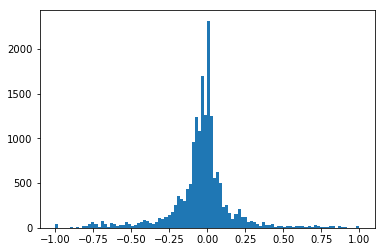

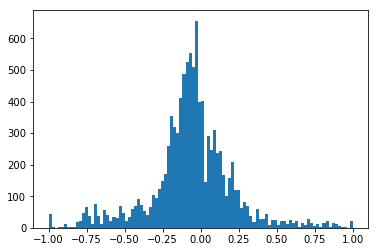

Training samples: 9148


In [ ]:
α = 0.25  # angle correction factor for left and right camera
batch_size = 32
model = compile_model()

# data sets being used for training
folders = ['d_mid_1','d_mid_2', 'd_round2', 'd_round3', 'd_bridge', 
           'd_last_curve', 'd_dirt', 'd_signs_curve', 'd_recover',
           'd_first_curve', 'd_track2', 'd_round1','round1_hq', 'round2_hq', 'round3_hq',]

# limits the amount of samples with angles in the same range. see read_logs()
limit=400
train_samples, validation_samples = read_logs(folders, limit)
# generators
train_generator = generator(train_samples, α=α, batch_size=batch_size, validation=False)
validation_generator = generator(validation_samples, α=α, batch_size=batch_size, validation=True)

In [ ]:
# fit and save model
hist = model.fit_generator(train_generator,
                           steps_per_epoch=len(train_samples)/batch_size,
                           validation_data=validation_generator,
                           validation_steps=len(validation_samples)/batch_size,
                           epochs=3,
                           verbose=2,
                           initial_epoch=0)

model.save('model.h5')

Epoch 1/3


In [ ]:
# plot the training and validation loss for each epoch
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()